# Convolutional Network


### Import packages


In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from dataset import SequenceDatasetCNN
from model import Convolutional
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from utils import plot_loss_epoch

### Load data


In [2]:
bidding_area = 3

df = pd.read_csv(f"data/NO{bidding_area}.csv")


df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

df = df[["consumption", "temperature"]]

df.to_csv("data/cnn.csv")

df.head()

,consumption,temperature
timestamp,,
2017-05-01 00:00:00+00:00,2674.838,5.5
2017-05-01 01:00:00+00:00,2678.188,4.0
2017-05-01 02:00:00+00:00,2678.341,3.7
2017-05-01 03:00:00+00:00,2684.172,3.2
2017-05-01 04:00:00+00:00,2733.345,2.7


### Split data


In [3]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=False)

### Normalization


In [4]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

df_train.head()

,consumption,temperature
timestamp,,
2017-05-01 00:00:00+00:00,-0.840752,-0.132928
2017-05-01 01:00:00+00:00,-0.833733,-0.326872
2017-05-01 02:00:00+00:00,-0.833413,-0.365661
2017-05-01 03:00:00+00:00,-0.821196,-0.430308
2017-05-01 04:00:00+00:00,-0.718170,-0.494956


### Define model


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = Convolutional(tw=100).to(device)
model

Convolutional(
  (conv_stack): Sequential(
    (0): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Loss function and optimizer


In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [7]:
tw = 100
pw = 1

train_dataset = SequenceDatasetCNN(df_train, time_window=tw, padding=pw)
val_dataset = SequenceDatasetCNN(df_val, time_window=tw, padding=pw)
test_dataset = SequenceDatasetCNN(df_test, time_window=tw, padding=pw)

### Create data loaders


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

### Training


In [9]:
epochs = 10

losses = []
losses_show = []
val_losses = []
for e in range(epochs):
    model.train()

    epoch_losses = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        preds = model(x)

        loss = loss_fn(preds, y)

        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        losses.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    print(f"Epoch {e+1} loss: {sum(epoch_losses) / len(epoch_losses)}")

    model.eval()
    val_loss = []
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y = y.squeeze()
        preds = model(x).squeeze()
        loss = loss_fn(preds, y)
        val_loss.append(loss)
    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {e+1} val loss: {avg_val_loss}")
    val_losses.append(avg_val_loss.item())

Epoch 1 loss: 0.06151435285274111
Epoch 1 val loss: 0.02115367166697979
Epoch 2 loss: 0.023203475228233166
Epoch 2 val loss: 0.01945393532514572
Epoch 3 loss: 0.017809729166436174
Epoch 3 val loss: 0.013875208795070648
Epoch 4 loss: 0.014839959565264887
Epoch 4 val loss: 0.015561047941446304
Epoch 5 loss: 0.01264856828674472
Epoch 5 val loss: 0.011038294062018394
Epoch 6 loss: 0.011451946210077028
Epoch 6 val loss: 0.009002306498587132
Epoch 7 loss: 0.01029641103856947
Epoch 7 val loss: 0.007706234231591225
Epoch 8 loss: 0.009617583099140617
Epoch 8 val loss: 0.008861367590725422
Epoch 9 loss: 0.008961278580975918
Epoch 9 val loss: 0.013387175276875496
Epoch 10 loss: 0.00871199955064286
Epoch 10 val loss: 0.011257743462920189


### Save model


In [10]:
models_directory = "models"

if not os.path.exists(models_directory):
    os.makedirs(models_directory)

torch.save(model.state_dict(), f"{models_directory}/cnn.pth")

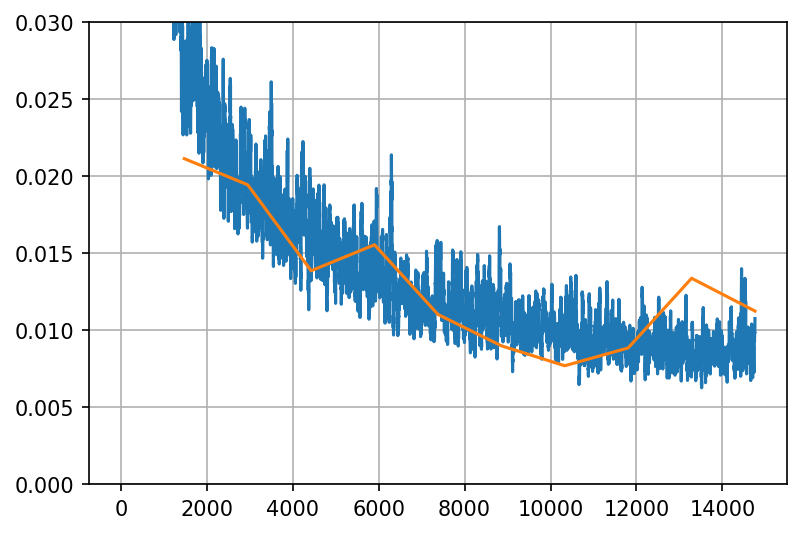

In [11]:
plot_loss_epoch(losses_show, val_losses)

### Testing using n in, 1 out


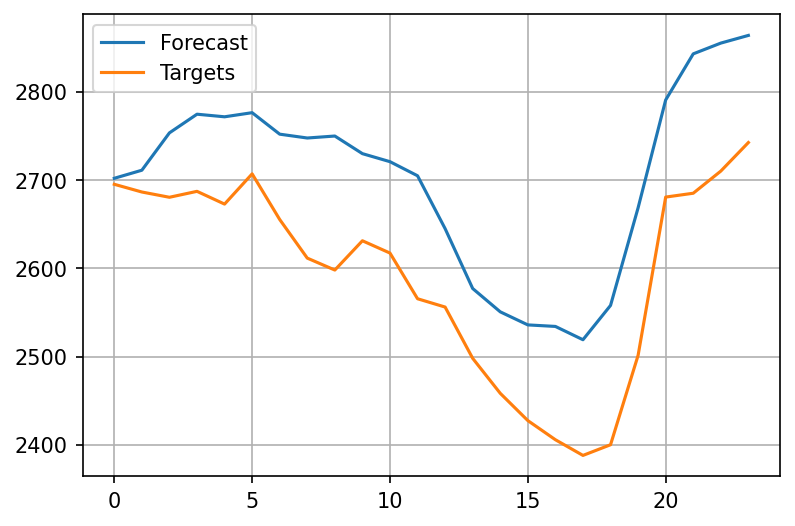

In [12]:
import copy

from matplotlib import pyplot as plt

start_point = 1100
fw = 24
tw = 100

historic_data = df_test.copy(deep=True)[start_point : start_point + tw + fw].values
targets = copy.deepcopy(historic_data)[tw : tw + fw][:, 0]

predictions = []

for i in range(fw):
    x = historic_data[i : tw + i].reshape(-1, 2)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    p = model(x)

    predictions.append(p.item())
    historic_data[-fw + i, 0] = p.item()


# denormalize
predictions = (
    np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
)
targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()